Credit to Hans-Petter Halvorsen and his "Mass-Spring-Damper system with Python" slides for equations and code framework

In [40]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

The following code graphs and displacement and velocity at a given time of the mass-spring-damper system. It uses the following equation: $$F(t) - c \frac{du}{dt} - kx(t) = m \frac{d^2 u}{dx^2}$$, where $t$ is the time that has passed, $F(t)$ is the external force applied to the system, $c$ is the damping constant, $k$ is the stiffness of the spring, and $m$ is the mass. 

In [3]:
tstart = 0
tstop = 60
increment = 0.1

# Initial condition
x_init = [0,0]
t = np.arange(tstart,tstop+1,increment)
F = int(input("How much force would you like to apply? "))

# Function that returns dx/dt
def mydiff(x, t):
    c = 4 # Damping constant
    k = 2 # Stiffness of the spring
    m = 20 # Mass
    # F = 5
    dx1dt = x[1]
    dx2dt = (F - c*x[1] - k*x[0])/m
    dxdt = [dx1dt, dx2dt]
    return dxdt

How much force would you like to apply? 5


In the following lines, $x_1$ is the position $x(t)$ and $x_2$ is the velocity $\frac{dx}{dt}$

It solves the system of equations
$$\begin{cases}
    \frac{dx_1}{dt} = x_2\\
    \frac{dx_2}{dt} = \frac{1}{m}(F - cx_2 - kx_1)
\end{cases} $$

where $x = x_1$ and $\frac{dx}{dt} = x_2$

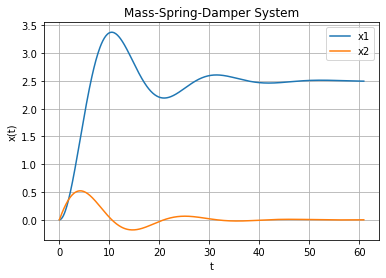

In [4]:
# Solve ODE
x = odeint(mydiff, x_init, t)
x1 = x[:,0]
x2 = x[:,1]
# Plotting results
plt.plot(t,x1)
plt.plot(t,x2)
plt.title('Mass-Spring-Damper System')
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend(["x1", "x2"])
plt.grid()
plt.show()

Credit to @enesdemirag and their "mass-spring-damper-system" code and explanation

In [41]:
from matplotlib import pyplot as plt
from matplotlib import animation

In [32]:
class Visualizer(object):
    def __init__(self, callback=None, interval=100.0, simulation_time=20.0, initial=(0, 0, 0, 0, 0, 0)):
        # Set loop interval
        self.interval = interval
        self.simulation_time = simulation_time
        # Create figure
        self.fig = plt.figure(1, figsize=(13, 6), dpi=80)
        # Create animation plot area
        self.animation_plot = self.fig.add_subplot(223)
        # Create position plot
        self.position_plot = self.fig.add_subplot(221)
        self.position_plot.set_xlim((0, self.simulation_time))
        self.position_plot.set_ylim((-20, 20))
        self.position_plot_patch = GraphPlot()
        self.position_plot.add_patch(self.position_plot_patch.first_patch)
        self.position_plot.add_patch(self.position_plot_patch.second_patch)
        self.position_plot.text(0.85, 0.8, 'Red:  x\nBlue: y', transform=self.position_plot.transAxes)
        self.position_plot.text(0.03, 0.9, 'Position Plot', transform=self.position_plot.transAxes)
        # Create velocity plot
        self.velocity_plot = self.fig.add_subplot(222)
        self.velocity_plot.set_xlim((0, self.simulation_time))
        self.velocity_plot.set_ylim((-20, 20))
        self.velocity_plot_patch = GraphPlot()
        self.velocity_plot.add_patch(self.velocity_plot_patch.first_patch)
        self.velocity_plot.add_patch(self.velocity_plot_patch.second_patch)
        self.velocity_plot.text(0.83, 0.8, 'Red:  Vx\nBlue: Vy', transform=self.velocity_plot.transAxes)
        self.velocity_plot.text(0.03, 0.9, 'Velocity Plot', transform=self.velocity_plot.transAxes)
        # Create acceleration plot
        self.acceleration_plot = self.fig.add_subplot(224)
        self.acceleration_plot.set_xlim((0, self.simulation_time))
        self.acceleration_plot.set_ylim((-30, 30))
        self.acceleration_plot_patch = GraphPlot()
        self.acceleration_plot.add_patch(self.acceleration_plot_patch.first_patch)
        self.acceleration_plot.add_patch(self.acceleration_plot_patch.second_patch)
        self.acceleration_plot.text(0.83, 0.8, 'Red:  Ax\nBlue: Ay', transform=self.acceleration_plot.transAxes)
        self.acceleration_plot.text(0.03, 0.9, 'Acceleration Plot', transform=self.acceleration_plot.transAxes)
        # Create dynamic label for simulation time
        self.sim_time_label = self.animation_plot.text(0.03, 0.9, '', transform=self.animation_plot.transAxes)
        # Set axes limit
        self.animation_plot.set_xlim((-20, 20))
        self.animation_plot.set_ylim((0, 30))
        # Create the mass object
        self.patch = plt.Rectangle((0, 0), width=10, height=5, fc='b')
        # Add the patches
        self.animation_plot.add_patch(self.patch)
        # Create animation core
        self.animate = animation.FuncAnimation(self.fig, self.animate, interval=self.interval,
                                               blit=True, repeat=True, init_func=self.init_func)
        # Set initials to zero
        self.sim_time = 0
        self.x = initial[0]
        self.y = initial[1]
        self.vx = initial[2]
        self.vy = initial[3]
        self.ax = initial[4]
        self.ay = initial[5]
        # Set callback
        self.cb_func = callback
        plt.show()

    def init_func(self):
        # Set initials to zero
        self.sim_time_label.set_text("")
        self.patch.xy = (0, 0)

        pos_plot = self.position_plot_patch.init_func()
        vel_plot = self.velocity_plot_patch.init_func()
        acc_plot = self.acceleration_plot_patch.init_func()
        ret_ = [self.patch, self.sim_time_label] + acc_plot + vel_plot + pos_plot
        # return the objects to be redrawn
        return ret_

    def animate(self, i):
        # update simulation time, i = n'th time that the method has
        # called, thus each represents self.interval ms of delay.
        self.sim_time = float(i) / (1000.0 / self.interval)

        # Update time
        self.sim_time_label.set_text("Simulation Time: " + str(self.sim_time))

        # Get object xy from callback
        (x, y) = self.cb_func(self.sim_time)
        # Set the position of object
        vx = (x - self.x) / (self.interval / 1000.0)
        vy = (y - self.y) / (self.interval / 1000.0)

        self.ax = (vx - self.vx) / (self.interval / 1000.0)
        self.ay = (vy - self.vy) / (self.interval / 1000.0)
        self.vx = vx
        self.vy = vy
        self.x = x
        self.y = y
        self.patch.xy = (x - 5, y - 2.5)

        pos_plot = self.position_plot_patch.update([[self.sim_time, x], [self.sim_time, y]])
        vel_plot = self.velocity_plot_patch.update([[self.sim_time, vx], [self.sim_time, vy]])
        acc_plot = self.acceleration_plot_patch.update([[self.sim_time, self.ax], [self.sim_time, self.ay]])
        ret_ = [self.patch, self.sim_time_label] + acc_plot + vel_plot + pos_plot
        # return the objects to be redrawn
        return ret_

In [33]:
class GraphPlot():
    def __init__(self):
        self.first_patch = plt.Polygon([[0, 0]], closed=None, fill=None, edgecolor='r')
        self.second_patch = plt.Polygon([[0, 0]], closed=None, fill=None, edgecolor='b')

    def init_func(self):
        self.first_patch.xy = [[0, 0]]
        self.second_patch.xy = [[0, 0]]
        return [self.first_patch, self.second_patch]

    def update(self, data):
        # Add current x position to x graph
        arr = self.first_patch.get_xy().tolist()
        arr.append(data[0])
        self.first_patch.xy = arr

        # Add current y position to y graph
        arr = self.second_patch.get_xy().tolist()
        arr.append(data[1])
        self.second_patch.xy = arr

        return [self.first_patch, self.second_patch]

In [1]:
dt = 0.05 # ΔT (sampling period) seconds

# Initial values
position = 15
velocity = 0
acceleration = 0

# Constants
mass = 1 # mass
k = 2.5 # spring coefficient
b = 0.3 # damping coefficient

# Callback Function
def set(arg):
    global dt, position, velocity, acceleration, mass, k, b # Get global variables

    spring_force = k * position # Fs = k * x
    damper_force = b * velocity # Fb = b * x'

    # If we leave the acceleration alone in equation
    # acceleration = - ((b * velocity) + (k * position)) / mass
    acceleration = - (spring_force + damper_force) / mass
    velocity += (acceleration * dt) # Integral(a) = v
    position += (velocity * dt) # Integral(v) = x

    return (position, 0) # Return position

# Start simulation
Visualizer(callback=set, interval=dt * 1000, simulation_time=30, initial=(position, 0, velocity, 0, acceleration, 0))

NameError: name 'Visualizer' is not defined

Taichi code:

In [2]:
import taichi as ti

[Taichi] version 1.1.2, llvm 10.0.0, commit f25cf4a2, osx, python 3.9.7
[I 09/21/22 13:03:02.329 934842] [shell.py:_shell_pop_print@33] Graphical python shell detected, using wrapped sys.stdout


In [ ]:
ti.init(arch=ti.gpu)

n = 320
pixels = ti.field(dtype=float, shape=(n * 2, n))

@ti.func
def complex_sqr(z):
    return ti.Vector([z[0]**2 - z[1]**2, z[1] * z[0] * 2])

@ti.kernel
def paint(t: float):
    for i, j in pixels:  # Parallelized over all pixels
        c = ti.Vector([-0.8, ti.cos(t) * 0.2])
        z = ti.Vector([i / n - 1, j / n - 0.5]) * 2
        iterations = 0
        while z.norm() < 20 and iterations < 50:
            z = complex_sqr(z) + c
            iterations += 1
        pixels[i, j] = 1 - iterations * 0.02

gui = ti.GUI("Julia Set", res=(n * 2, n))

i = 0
while gui.running:
    paint(i * 0.03)
    gui.set_image(pixels)
    gui.show()
    i = i + 1

In [ ]:
import numpy as np
X = np.random.random((1, 2))
Y = np.random.random((1, 2))
Z = np.random.random((1, 2))
print(X)
print(Y)
print(Z)
gui = ti.GUI("triangles", res=(400, 400))
i = 0
j = 0
while gui.running:
    gui.triangles(a=X+i, b=Y, c=Z, color=0xED553B)
    if j < 100:
        i = 0.01
    elif j < 200:
        i = -0.01
    else:
        j = 0
    j += 1
    gui.show()

using GUI interface to control a ball drawn on the screen

In [27]:
gui = ti.GUI('Title', (640, 480))
pos = np.random.random((1,2))

while gui.running:
    gui.get_event()  # must be called before is_pressed
    if gui.is_pressed('a', ti.GUI.LEFT):
        pos[0,0]-=0.01
    elif gui.is_pressed('d', ti.GUI.RIGHT):
        pos[0,0]+=0.01
    elif gui.is_pressed('w', ti.GUI.UP):
        pos[0,1]+=0.01
    elif gui.is_pressed('s', ti.GUI.DOWN):
        pos[0,1]-=0.01
    gui.circles(pos, radius=5, palette=[0x068587],palette_indices=np.array([0]))
    gui.show()


In [19]:
pos = np.random.random((1, 2))
# Create an array of 50 integer elements whose values are randomly 0, 1, 2
# 0 corresponds to 0x068587
# 1 corresponds to 0xED553B
# 2 corresponds to 0xEEEEF0
print(pos)
print(type(pos))
print(np.shape(pos))
indices = np.random.randint(0, 2, size=(1,))
gui = ti.GUI("circles", res=(400, 400))

while gui.running:
    gui.circles(pos, radius=5, palette=[0x068587, 0xED553B, 0xEEEEF0], palette_indices=indices)
    gui.show()


[[0.88568889 0.97643073]]
<class 'numpy.ndarray'>
(1, 2)


In [29]:
import taichi as ti
ti.init()

N = 8
dt = 1e-5

x = ti.Vector.field(2, dtype=ti.f32, shape=N, needs_grad=True)  # particle positions
v = ti.Vector.field(2, dtype=ti.f32, shape=N)  # particle velocities
U = ti.field(dtype=ti.f32, shape=(), needs_grad=True)  # potential energy


@ti.kernel
def compute_U():
    for i, j in ti.ndrange(N, N):
        r = x[i] - x[j]
        # r.norm(1e-3) is equivalent to ti.sqrt(r.norm()**2 + 1e-3)
        # This is to prevent 1/0 error which can cause wrong derivative
        U[None] += -1 / r.norm(1e-3)  # U += -1 / |r|


@ti.kernel
def advance():
    for i in x:
        v[i] += dt * -x.grad[i]  # dv/dt = -dU/dx
    for i in x:
        x[i] += dt * v[i]  # dx/dt = v


def substep():
    with ti.ad.Tape(loss=U):
        # Kernel invocations in this scope will later contribute to partial derivatives of
        # U with respect to input variables such as x.
        compute_U(
        )  # The tape will automatically compute dU/dx and save the results in x.grad
    advance()


@ti.kernel
def init():
    for i in x:
        x[i] = [ti.random(), ti.random()]


init()
gui = ti.GUI('Autodiff gravity')
while gui.running:
    for i in range(50):
        substep()
    gui.circles(x.to_numpy(), radius=3)
    gui.show()

[Taichi] Starting on arch=x64


In [62]:
import math

gui = ti.GUI('Spring-Mass System', (640, 480))
#pos = np.array([[0.5, 0.5]])
xpos = 0.5
ypos = 0.5
mouse_y = 0 # just a placeholder

mass = gui.slider('Mass', 5, 15, step=1)
reset = gui.button('Reset')

mass.value = 10

while gui.running:
    # gui.get_event()  # must be called before is_pressed
    for e in gui.get_events(gui.PRESS):
        if e.key == 'a':
            xpos -= 0.01
            print("moving")
        elif e.key == gui.ESCAPE:
            gui.running = False
            print("ending sim")
            exit()
        elif e.key == gui.LMB:
            xpos = gui.get_cursor_pos()[0]
        elif e.key == reset:
            xpos = 0.5
    
    gui.circle((xpos,ypos), radius=mass.value)
    gui.show()

this happened
this happened
this happened
this happened
this happened
this happened
ending sim


Now trying to make it move like a spring

This next one is unfinished:

In [3]:
import math
ti.init()

dt = 1e-5

# k = spring constant
# m = mass
# c = damping constant
def calc_angular(k, m, c): 
    return math.sqrt(k/m - math.pow(c/(2*m), 2))

gui = ti.GUI('Spring-Mass System', (640, 480))
#pos = np.array([[0.5, 0.5]])
xpos = 0.5
ypos = 0.5
mouse_y = 0 # just a placeholder

mass = gui.slider('Mass', 5, 15, step=1)
damping = gui.slider('Damping', 0, 100, step=5)
spring = gui.slider('Spring Constant', 0, 1000, step=20)
reset = gui.button('Reset')

mass.value = 5
damping.value = 2
spring.value = 5

while gui.running:
    for e in gui.get_events(gui.PRESS):
        if e.key == gui.ESCAPE:
            gui.running = False
            print("ending sim")
            exit()
        elif e.key == gui.LMB: 
            # now reset it and calculate sinusoid with a new initial amplitude
            xpos = gui.get_cursor_pos()[0]
            a_0 = abs(0.5-xpos)
        elif e.key == reset:
            xpos = 0.5
    
    gui.circle((xpos,ypos), radius=mass.value)
    gui.show()

    
"""
x = ti.Vector.field(2, dtype=ti.f32, shape=N, needs_grad=True)  # particle positions
v = ti.Vector.field(2, dtype=ti.f32, shape=N)  # particle velocities
U = ti.field(dtype=ti.f32, shape=(), needs_grad=True)  # potential energy


@ti.kernel
def compute_U():
    for i, j in ti.ndrange(N, N):
        r = x[i] - x[j]
        # r.norm(1e-3) is equivalent to ti.sqrt(r.norm()**2 + 1e-3)
        # This is to prevent 1/0 error which can cause wrong derivative
        U[None] += -1 / r.norm(1e-3)  # U += -1 / |r|


@ti.kernel
def advance():
    for i in x:
        v[i] += dt * -x.grad[i]  # dv/dt = -dU/dx
    for i in x:
        x[i] += dt * v[i]  # dx/dt = v


def substep():
    with ti.ad.Tape(loss=U):
        # Kernel invocations in this scope will later contribute to partial derivatives of
        # U with respect to input variables such as x.
        compute_U(
        )  # The tape will automatically compute dU/dx and save the results in x.grad
    advance()


@ti.kernel
def init():
    for i in x:
        x[i] = [ti.random(), ti.random()]


init()
gui = ti.GUI('Autodiff gravity')
while gui.running:
    for i in range(50):
        substep()
    gui.circles(x.to_numpy(), radius=3)
    gui.show()
"""

[Taichi] Starting on arch=x64
ending sim


"\nx = ti.Vector.field(2, dtype=ti.f32, shape=N, needs_grad=True)  # particle positions\nv = ti.Vector.field(2, dtype=ti.f32, shape=N)  # particle velocities\nU = ti.field(dtype=ti.f32, shape=(), needs_grad=True)  # potential energy\n\n\n@ti.kernel\ndef compute_U():\n    for i, j in ti.ndrange(N, N):\n        r = x[i] - x[j]\n        # r.norm(1e-3) is equivalent to ti.sqrt(r.norm()**2 + 1e-3)\n        # This is to prevent 1/0 error which can cause wrong derivative\n        U[None] += -1 / r.norm(1e-3)  # U += -1 / |r|\n\n\n@ti.kernel\ndef advance():\n    for i in x:\n        v[i] += dt * -x.grad[i]  # dv/dt = -dU/dx\n    for i in x:\n        x[i] += dt * v[i]  # dx/dt = v\n\n\ndef substep():\n    with ti.ad.Tape(loss=U):\n        # Kernel invocations in this scope will later contribute to partial derivatives of\n        # U with respect to input variables such as x.\n        compute_U(\n        )  # The tape will automatically compute dU/dx and save the results in x.grad\n    advance()

This is a simpler version of the one above (no sliders): 

In [ ]:
import math
import taichi as ti

ti.init()

t = 0
dt = 1e-4

# Why do i need the substeps?
substeps = 10

x = ti.field(dtype=ti.f32, shape=(2,)) # x[0] = xpos, x[1] = ypos
mass = ti.field(dtype=ti.f32, shape=())
damping = ti.field(dtype=ti.f32, shape=())
spring = ti.field(dtype=ti.f32, shape=())
base = ti.field(dtype=ti.f32, shape=(2,))

# k = spring constant
# m = mass
# c = damping constant
def calc_angular(k, m, c): 
    return math.sqrt(k/m - math.pow(c/(2*m), 2))

@ti.kernel
def substep():
    # using an explicit Euler integration scheme
    pass

def main():
    gui = ti.GUI('Sinusoidal Motion', (640, 480))
    
    x[0] = 0.5
    x[1] = 0.5
    base[0] = 0.5
    base[1] = 0.5
    # initialize values
    mass[None] = 5
    damping[None] = 2
    spring[None] = 5
    
    while True:
        for e in gui.get_events(ti.GUI.PRESS):
            if e.key in [ti.GUI.ESCAPE, ti.GUI.EXIT]:
                exit()
            elif e.key == ti.GUI.LMB: #restarting sim from different spot
                # for now only simulating the sinusoidal motion in 1D
                x[0] = e.pos[0]
        
        # move stuff
        for step in range(substeps):
            substep()
        
        # Draw springs
        X = x.to_numpy()
        B = base.to_numpy()
        gui.line(begin=X, end=B, radius = 2, color=0x444444)
    
        gui.circle((x[0], x[1]), radius = mass[None])
        gui.show()
    
    
if __name__ == '__main__':
    main()



[Taichi] Starting on arch=x64
